In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
import time
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tabulate import tabulate
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange
from sklearn.metrics import accuracy_score
from scipy import stats



In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/10243,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/10243,1), 'GB')

Using device: cpu


In [13]:
# Load the demographic data
demo_data = pd.read_csv('demographic_data.csv')
print('Class Frequencies\n',demo_data['TDorSCI'].value_counts())
# Encoding the target variable
demo_data['TDorSCI'] = demo_data['TDorSCI'].map({'TD': 0, 'SCI': 1})
# Load the DTI data
dti_data = pd.read_csv('DTI_data_averaged.csv')

# Merge the two datasets on the 'UID' column
merged_data = demo_data.merge(dti_data, on='UID')

# Fill missing values with -1
filled_data = merged_data.fillna(-1)

# Export filled_data to a CSV file
filled_data.to_csv('PreProcessedData.csv', index=False)

Class Frequencies
 TD     84
SCI    54
Name: TDorSCI, dtype: int64


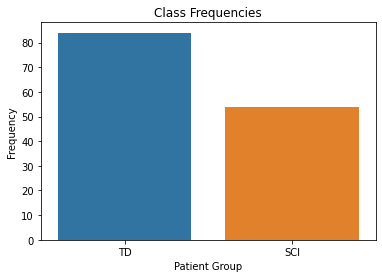

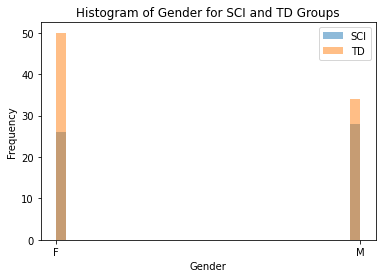

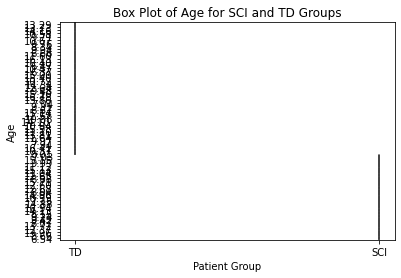

In [14]:
# Separate SCI and TD groups
sci_data = demo_data[demo_data['TDorSCI'] == 1]
td_data = demo_data[demo_data['TDorSCI'] == 0]

# Bar plot of class frequencies
sns.countplot(x='TDorSCI', data=demo_data)
plt.xticks(ticks=[0, 1], labels=['TD', 'SCI'])
plt.xlabel('Patient Group')
plt.ylabel('Frequency')
plt.title('Class Frequencies')
plt.show()

# Histogram of demographic feature
plt.hist(sci_data['Gender'], alpha=0.5, label='SCI', bins=30)
plt.hist(td_data['Gender'], alpha=0.5, label='TD', bins=30)
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.title('Histogram of Gender for SCI and TD Groups')
plt.legend(loc='upper right')
plt.show()

# Box plot of demographic feature
sns.boxplot(x='TDorSCI', y='Age', data=demo_data)
plt.xticks(ticks=[0, 1], labels=['TD', 'SCI'])
plt.xlabel('Patient Group')
plt.ylabel('Age')
plt.title('Box Plot of Age for SCI and TD Groups')
plt.show()

In [15]:
# Define the features to be used in the LSTM model
dti_features = ['FA_mean', 'ADC_mean', 'RA_mean', 'MD_mean', 'AD_mean', 'RD_mean']
demo_features = ['Age']

## Data Pre-Processing

In [16]:
#Reshape for PyTorch Model 
grouped_dti_data = filled_data.groupby('UID').apply(lambda x: x[dti_features].astype(float).values.reshape(6, -1))
grouped_demo_data = filled_data.groupby('UID').apply(lambda x: x[demo_features].astype(float).values[0])

# Convert the grouped data to NumPy arrays
X_dti = np.stack(grouped_dti_data.values)
X_demo = np.stack(grouped_demo_data.values)

# Get the labels for each patient, ensuring the same order as X
y = np.array([demo_data.loc[demo_data['UID'] == uid, 'TDorSCI'].iloc[0] for uid in grouped_dti_data.index])

print(X_dti.shape)
print(X_demo.shape)
print(y.shape)


(132, 6, 18)
(132, 1)
(132,)


In [17]:

grouped_dti_data = filled_data.groupby('UID').apply(lambda x: x[dti_features].astype(float).values.reshape(6, -1))

# Convert the grouped data to NumPy arrays
X_dti = np.stack(grouped_dti_data.values)

# Reshape X_dti to concatenate the 6 DTI features
X_dti = X_dti.reshape(X_dti.shape[0], -1)

# Get the labels for each patient, ensuring the same order as X
y = np.array([demo_data.loc[demo_data['UID'] == uid, 'TDorSCI'].iloc[0] for uid in grouped_dti_data.index])

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_dti, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(105, 108)
(27, 108)
(105,)
(27,)


Test accuracy: 0.7247899159663865
              precision    recall  f1-score   support

         SCI       0.73      0.91      0.81       304
          TD       0.71      0.40      0.51       172

    accuracy                           0.72       476
   macro avg       0.72      0.65      0.66       476
weighted avg       0.72      0.72      0.70       476

AUC: 0.6545287637698899


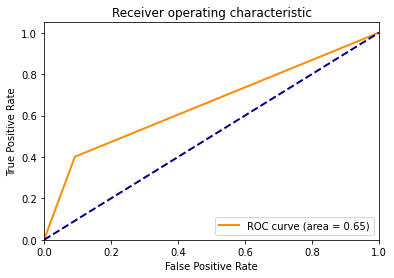

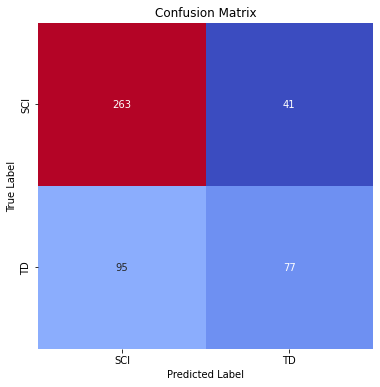

Sensitivity: 0.448 (95% CI: 0.373, 0.522)
Specificity: 0.865 (95% CI: 0.827, 0.904)


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the features to be used in the SVM model
dti_features = ['FA_mean', 'ADC_mean', 'RA_mean', 'MD_mean', 'AD_mean', 'RD_mean']

# Get the DTI feature data and labels
X_dti = filled_data[dti_features].values.astype(float)
y = filled_data['TDorSCI'].values.astype(int)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_dti, y, test_size=0.2, random_state=42)

# Fit the SVM on the training data
svm = SVC(kernel='linear', probability = True)
svm.fit(X_train, y_train)

# Evaluate the SVM on the test data
y_pred = svm.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)

print('Test accuracy:', test_acc)
# Print the classification report
target_names = ['SCI', 'TD']
print(classification_report(y_test, y_pred, target_names=target_names))

# Compute the false positive rate, true positive rate, and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Print the AUC
print(f"AUC: {roc_auc}")

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# Compute predicted probabilities
predicted_probs = svm.predict_proba(X_test)[:,1]

# Calculate predicted labels
predicted_labels = np.where(predicted_probs > 0.5, 1, 0)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cbar=False, cmap="coolwarm", xticklabels=["SCI", "TD"], yticklabels=["SCI", "TD"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Calculate sensitivity and specificity with confidence intervals
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

alpha = 0.05  # 95% confidence interval
z = stats.norm.ppf(1 - alpha / 2)
se_sensitivity = np.sqrt(sensitivity * (1 - sensitivity) / (tp + fn))
se_specificity = np.sqrt(specificity * (1 - specificity) / (tn + fp))
ci_sensitivity = (sensitivity - z * se_sensitivity, sensitivity + z * se_sensitivity)
ci_specificity = (specificity - z * se_specificity, specificity + z * se_specificity)

print(f'Sensitivity: {sensitivity:.3f} (95% CI: {ci_sensitivity[0]:.3f}, {ci_sensitivity[1]:.3f})')
print(f'Specificity: {specificity:.3f} (95% CI: {ci_specificity[0]:.3f}, {ci_specificity[1]:.3f})')


Normalized confusion matrix
[[0.91 0.09]
 [0.6  0.4 ]]


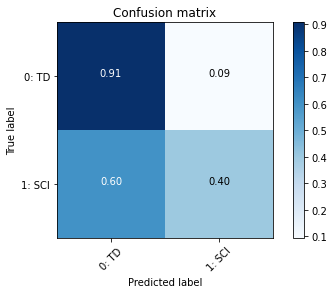

In [19]:
# Confusion Matrix
import itertools 

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
def cm(y_true, y_pred):
    cnf_matrix = confusion_matrix(y_true, y_pred)
    np.set_printoptions(precision=2)
    plt.figure()
    class_names = ['0: TD','1: SCI']
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix')
    
cm(y_test,y_pred)

## Comparison

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# Define the features to be used in the models
dti_features = ['FA_mean', 'ADC_mean', 'RA_mean', 'MD_mean', 'AD_mean', 'RD_mean']

# Get the DTI feature data and labels
X_dti = filled_data[dti_features].values.astype(float)
y = filled_data['TDorSCI'].values.astype(int)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_dti, y, test_size=0.2, random_state=42)

# SVM model
svm = SVC(kernel='linear', probability=True)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
test_acc_svm = accuracy_score(y_test, y_pred_svm)
print('SVM Test accuracy:', test_acc_svm)

# Gradient Boosting model
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
test_acc_gb = accuracy_score(y_test, y_pred_gb)
print('Gradient Boosting Test accuracy:', test_acc_gb)

# Logistic Regression model
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
test_acc_lr = accuracy_score(y_test, y_pred_lr)
print('Logistic Regression Test accuracy:', test_acc_lr)

# K-NN model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
test_acc_knn = accuracy_score(y_test, y_pred_knn)
print('K-NN Test accuracy:', test_acc_knn)

# Random Forest model
rf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
test_acc_rf = accuracy_score(y_test, y_pred_rf)
print('Random Forest Test accuracy:', test_acc_rf)

# Ensemble model
ensemble = VotingClassifier(estimators=[('svm', svm), ('gb', gb), ('lr', lr), ('knn', knn), ('rf', rf)], voting='soft')
ensemble.fit(X_train, y_train)
y_pred_ensemble = ensemble.predict(X_test)
test_acc_ensemble = accuracy_score(y_test, y_pred_ensemble)
print('Ensemble Test accuracy:', test_acc_ensemble)

# Print the classification report
target_names = ['SCI', 'TD']
print('\nClassification Report for SVM:')
print(classification_report(y_test, y_pred_svm, target_names=target_names))

print('\nClassification Report for Gradient Boosting:')
print(classification_report(y_test, y_pred_gb, target_names=target_names))

print('\nClassification Report for Logistic Regression:')
print(classification_report(y_test, y_pred_lr, target_names=target_names))

print('\nClassification Report for K-NN:')
print(classification_report(y_test, y_pred_knn, target_names=target_names))

print('\nClassification Report for Random Forest:')
print(classification_report(y_test, y_pred_rf, target_names=target_names))

print('\nClassification Report for Ensemble:')
print(classification_report(y_test, y_pred_ensemble, target_names=target_names))



SVM Test accuracy: 0.7247899159663865
Gradient Boosting Test accuracy: 0.6974789915966386
Logistic Regression Test accuracy: 0.7100840336134454
K-NN Test accuracy: 0.6785714285714286
Random Forest Test accuracy: 0.7205882352941176
Ensemble Test accuracy: 0.7184873949579832

Classification Report for SVM:
              precision    recall  f1-score   support

         SCI       0.73      0.91      0.81       304
          TD       0.71      0.40      0.51       172

    accuracy                           0.72       476
   macro avg       0.72      0.65      0.66       476
weighted avg       0.72      0.72      0.70       476


Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

         SCI       0.74      0.82      0.78       304
          TD       0.60      0.48      0.53       172

    accuracy                           0.70       476
   macro avg       0.67      0.65      0.65       476
weighted avg       0.69      0.70      0.69      

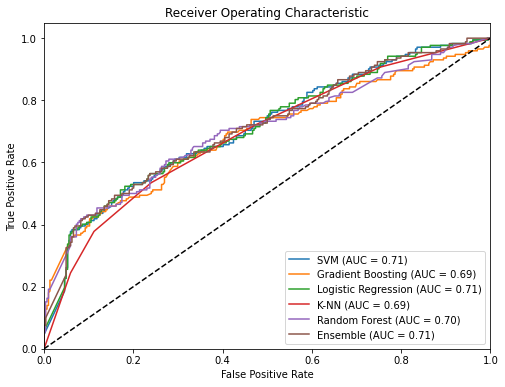

In [24]:
# Calculate the predicted probabilities for each model
y_pred_svm_prob = svm.predict_proba(X_test)[:, 1]
y_pred_gb_prob = gb.predict_proba(X_test)[:, 1]
y_pred_lr_prob = lr.predict_proba(X_test)[:, 1]
y_pred_knn_prob = knn.predict_proba(X_test)[:, 1]
y_pred_rf_prob = rf.predict_proba(X_test)[:, 1]
y_pred_ensemble_prob = ensemble.predict_proba(X_test)[:, 1]

# Calculate the false positive rate and true positive rate for each model
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_svm_prob)
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_pred_gb_prob)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr_prob)
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_knn_prob)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf_prob)
fpr_ensemble, tpr_ensemble, _ = roc_curve(y_test, y_pred_ensemble_prob)

# Calculate the AUC for each model
auc_svm = auc(fpr_svm, tpr_svm)
auc_gb = auc(fpr_gb, tpr_gb)
auc_lr = auc(fpr_lr, tpr_lr)
auc_knn = auc(fpr_knn, tpr_knn)
auc_rf = auc(fpr_rf, tpr_rf)
auc_ensemble = auc(fpr_ensemble, tpr_ensemble)

# Plot the ROC curve for each model
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, label='SVM (AUC = %0.2f)' % auc_svm)
plt.plot(fpr_gb, tpr_gb, label='Gradient Boosting (AUC = %0.2f)' % auc_gb)
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression (AUC = %0.2f)' % auc_lr)
plt.plot(fpr_knn, tpr_knn, label='K-NN (AUC = %0.2f)' % auc_knn)
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = %0.2f)' % auc_rf)
plt.plot(fpr_ensemble, tpr_ensemble, label='Ensemble (AUC = %0.2f)' % auc_ensemble)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


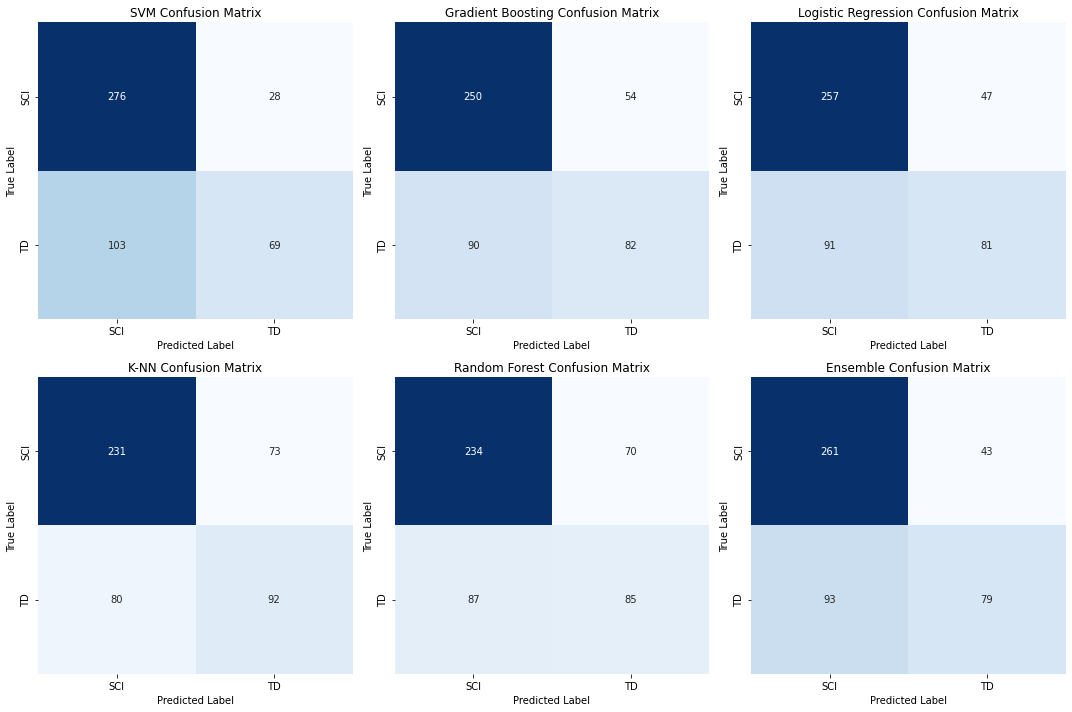

In [31]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import numpy as np

# Define the features to be used in the models
dti_features = ['FA_mean', 'ADC_mean', 'RA_mean', 'MD_mean', 'AD_mean', 'RD_mean']

# Get the DTI feature data and labels
X_dti = filled_data[dti_features].values.astype(float)
y = filled_data['TDorSCI'].values.astype(int)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_dti, y, test_size=0.2, random_state=42)

# Define the models
svm = SVC(kernel='linear', probability=True)
gb = GradientBoostingClassifier(random_state=42)
lr = LogisticRegression(random_state=42)
knn = KNeighborsClassifier()
rf = RandomForestClassifier(random_state=42)
ens = VotingClassifier(estimators=[('svm', svm), ('gb', gb), ('lr', lr), ('knn', knn), ('rf', rf)])

# Train the models
svm.fit(X_train, y_train)
gb.fit(X_train, y_train)
lr.fit(X_train, y_train)
knn.fit(X_train, y_train)
rf.fit(X_train, y_train)
ens.fit(X_train, y_train)

# Make predictions on the test set for each model
y_pred_svm = svm.predict(X_test)
y_pred_gb = gb.predict(X_test)
y_pred_lr = lr.predict(X_test)
y_pred_knn = knn.predict(X_test)
y_pred_rf = rf.predict(X_test)
y_pred_ens = ens.predict(X_test) # Add this line to define y_pred_ens

# Compute the predicted probabilities for the SVM and logistic regression models
y_pred_svm_prob = svm.predict_proba(X_test)[:, 1]
y_pred_lr_prob = lr.predict_proba(X_test)[:, 1]

# Calculate the false positive rate and true positive rate for each model
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_svm_prob)
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_pred_gb)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr_prob)
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_knn)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
fpr_ens, tpr_ens, _ = roc_curve(y_test, y_pred_ens)

# Calculate the AUC for each model
auc_svm = auc(fpr_svm, tpr_svm)
auc_gb = auc(fpr_gb, tpr_gb)
auc_lr = auc(fpr_lr, tpr_lr)
auc_knn = auc(fpr_knn, tpr_knn)
auc_rf = auc(fpr_rf, tpr_rf)
auc_ens = auc(fpr_ens, tpr_ens)
# Make predictions on the test set for each model
y_pred_svm = svm.predict(X_test)
y_pred_gb = gb.predict(X_test)
y_pred_lr = lr.predict(X_test)
y_pred_knn = knn.predict(X_test)
y_pred_rf = rf.predict(X_test)
y_pred_ens = ens.predict(X_test) # Add this line to define y_pred_ens

# Create confusion matrices for each model
cm_svm = confusion_matrix(y_test, y_pred_svm)
cm_gb = confusion_matrix(y_test, y_pred_gb)
cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_knn = confusion_matrix(y_test, y_pred_knn)
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_ens = confusion_matrix(y_test, y_pred_ens)

# Plot the confusion matrices
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,10))

sns.heatmap(cm_svm, annot=True, cmap="Blues", cbar=False, fmt="d", ax=axs[0, 0], xticklabels=target_names, yticklabels=target_names)
axs[0, 0].set_title("SVM Confusion Matrix")
axs[0, 0].set_xlabel("Predicted Label")
axs[0, 0].set_ylabel("True Label")

sns.heatmap(cm_gb, annot=True, cmap="Blues", cbar=False, fmt="d", ax=axs[0, 1], xticklabels=target_names, yticklabels=target_names)
axs[0, 1].set_title("Gradient Boosting Confusion Matrix")
axs[0, 1].set_xlabel("Predicted Label")
axs[0, 1].set_ylabel("True Label")

sns.heatmap(cm_lr, annot=True, cmap="Blues", cbar=False, fmt="d", ax=axs[0, 2], xticklabels=target_names, yticklabels=target_names)
axs[0, 2].set_title("Logistic Regression Confusion Matrix")
axs[0, 2].set_xlabel("Predicted Label")
axs[0, 2].set_ylabel("True Label")

sns.heatmap(cm_knn, annot=True, cmap="Blues", cbar=False, fmt="d", ax=axs[1, 0], xticklabels=target_names, yticklabels=target_names)
axs[1, 0].set_title("K-NN Confusion Matrix")
axs[1, 0].set_xlabel("Predicted Label")
axs[1, 0].set_ylabel("True Label")

sns.heatmap(cm_rf, annot=True, cmap="Blues", cbar=False, fmt="d", ax=axs[1, 1], xticklabels=target_names, yticklabels=target_names)
axs[1, 1].set_title("Random Forest Confusion Matrix")
axs[1, 1].set_xlabel("Predicted Label")
axs[1, 1].set_ylabel("True Label")

sns.heatmap(cm_ens, annot=True, cmap="Blues", cbar=False, fmt="d", ax=axs[1, 2], xticklabels=target_names, yticklabels=target_names)
axs[1, 2].set_title("Ensemble Confusion Matrix")
axs[1, 2].set_xlabel("Predicted Label")
axs[1, 2].set_ylabel("True Label")

plt.tight_layout()
plt.show()


In [33]:
from sklearn.model_selection import GroupKFold
from sklearn.svm import SVC

# Define the features to be used in the SVM model
dti_features = ['FA_mean', 'ADC_mean', 'RA_mean', 'MD_mean', 'AD_mean', 'RD_mean']

# Get the DTI feature data, labels, and patient UIDs
X_dti = filled_data[dti_features].values.astype(float)
y = filled_data['TDorSCI'].values.astype(int)
uids = filled_data['UID'].values

# Split the data into train and test sets using GroupKFold
gkf = GroupKFold(n_splits=5)
for train_indices, test_indices in gkf.split(X_dti, y, uids):
    X_train, y_train, uids_train = X_dti[train_indices], y[train_indices], uids[train_indices]
    X_test, y_test, uids_test = X_dti[test_indices], y[test_indices], uids[test_indices]
    
    # Fit the SVM on the training data for this group
    svm = SVC(kernel='linear', probability=True)
    svm.fit(X_train, y_train)
    
    # Evaluate the SVM on the test data for this group
    y_pred = svm.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred)
    
    print('Test accuracy:', test_acc)


Test accuracy: 0.6995884773662552
Test accuracy: 0.8148148148148148
Test accuracy: 0.7115384615384616
Test accuracy: 0.6581196581196581
Test accuracy: 0.5790598290598291
